# Expansion shmexpansion

In calculus, we were taught that this function does not have a Taylor expansion at $x=0$:

$$f(x) = \cases{\exp(-1/x^2) \text{ , } x\ne 0 \\ 0 \text{ , } x = 0}$$

This is because although the function is smooth along the real axis, it is discontinuous in the complex plane. All of its derivatives at $x=0$ are 0. It is infinitely flat around 0! 

Let's plot it and see.

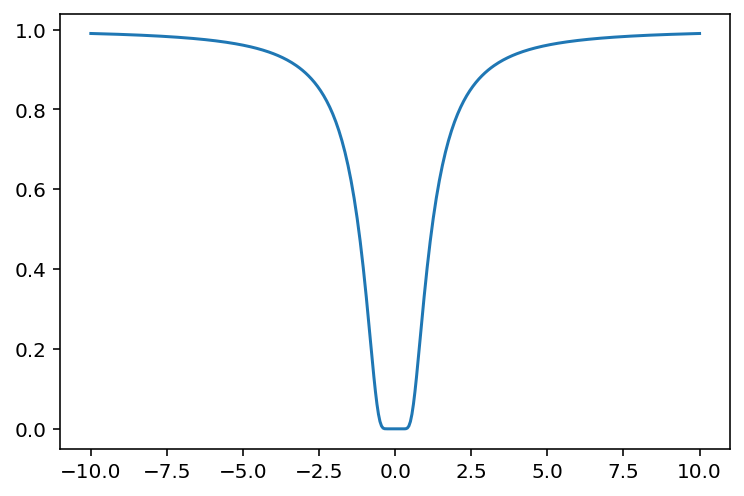

In [147]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    r = np.exp(-1 / x ** 2)
    r[x == 0] = 0
    return r

rg = np.linspace(-10, 10, 401)
plt.plot(rg, f(rg))

Doesn't look too promising! It's very flat at 0. All of its derivatives are exactly 0. However, even though its Taylor expansion is null, we can still form a perfectly good local polynomical approximation, that is, approximating the functions as the sum of a constant, a linear trend, a quadratic, etc.. The idea here is to probe the function at normally distributed locations around 0. We then perform a polynomial regression to approximate the function at these randomly chosen location. This is equivalent to minimizing the expected sum-of-squares error:

$$\mathbb E_{p(x)}[(f(x) - h_0(x) - h_2(x) x ^2 - h_4(x) x ^ 4 + \dots)^2]$$

Note that we only include the even coefficients $h_i(x), i \in [0, 2, 4, \ldots]$ in this expression, since we know the function is even, $f(x) = f(-x)$.

Let's roll!

Text(0.5, 1.0, 'Approximating exp(-1/x^2) with polynomials')

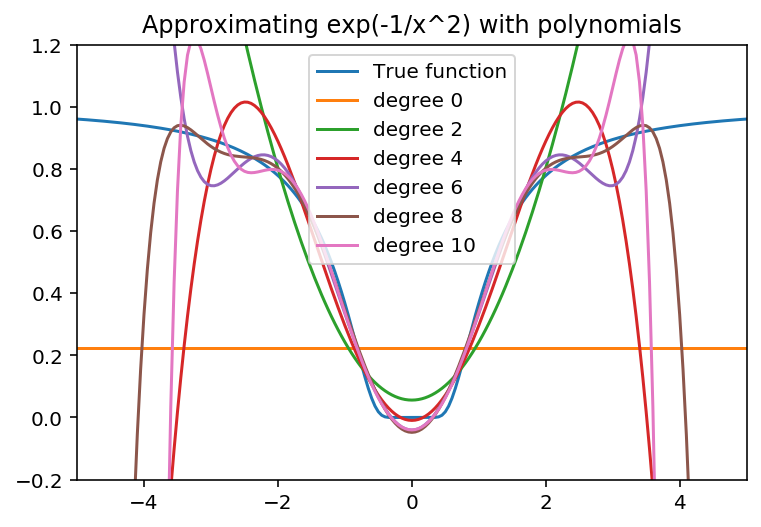

In [195]:
def get_expansion(sigma):
    nexpansion = 6
    N = 1000
    X = sigma * np.random.randn(N)
    rnums = X.copy()
    y = f(X)

    Xs = []
    coefficients = []

    # Collect even powers of $x$ to form a polynomial regression.
    Rs = []
    for i in range(0, 2 * (nexpansion + 1), 2):
        Rs.append(rg ** i)
        Xs.append(X ** i)

    # Tiny amount of trickery: orthogonalize the columns of our design matrix.
    # This way, lower power coefficients won't change when we add higher power coefficients.
    X = np.array(Xs).T
    r = np.sqrt((X ** 2).sum(0, keepdims=True))
    X = X / r
    R = np.array(Rs).T
    R = R / r

    for i in range(1, X.shape[1]):
        w = X[:, :i].T.dot(X[:, i])
        X[:, i] -= X[:, :i].dot(w)
        a = np.sqrt((X[:, i] ** 2).sum(0))
        X[:, i] /= a
        R[:, i] -= R[:, :i].dot(w)
        R[:, i] /= a

    # Check that the design matrix is indeed orthonormal.
    np.testing.assert_allclose(X.T.dot(X), np.eye(X.shape[1]), atol=1E-6)

    # Perform the polynomial regression. Note that we don't have to invert X.T.dot(X),
    # since that is the identity matrix.
    w_hat = (X.T @ y)
    return w_hat, R

w_hat, R = get_expansion(1.0)

leg = ["True function"]
plt.plot(rg, f(rg))
for i in range(1, nexpansion+1):
    plt.plot(rg, R[:, :i].dot(w_hat[:i]))
    leg.append("degree %d" % ((i - 1) * 2))
plt.legend(leg)
plt.ylim((-.2, 1.2))
plt.xlim((-5, 5))
plt.title('Approximating exp(-1/x^2) with polynomials')

Even though the function has no derivatives at 0, it can still be approximated by a polynomial! In the Taylor expansion, we only probe the function at 0. However, in the polynomial regression, we probe it at multiple points. While the Taylor expansion is unique once the degree is known, there are an infinite number of polynomial expansions that minimize different empirical risks. We can choose to minimize the empirical risk over a larger range of values of x by probing with normally distributed x values with a larger $\sigma$:

Text(0.5, 1.0, 'Approximating exp(-1/x^2) with polynomials, $\\sigma$ = 2')

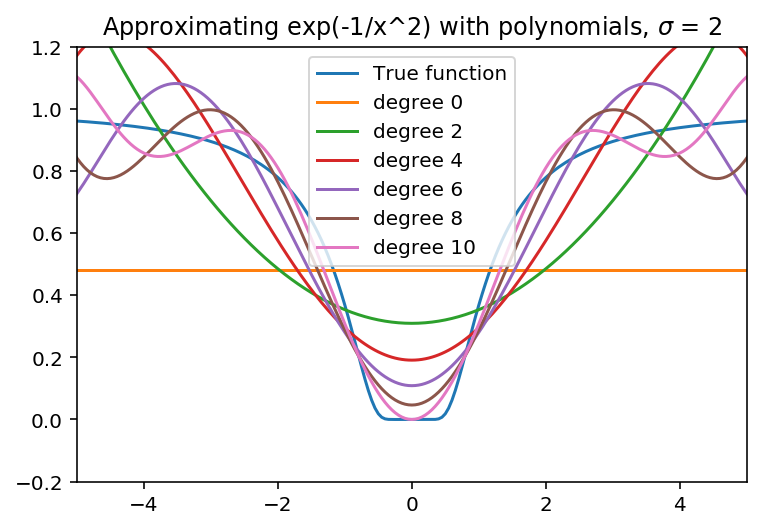

In [196]:
w_hat, R = get_expansion(2.0)

leg = ["True function"]
plt.plot(rg, f(rg))
for i in range(1, nexpansion+1):
    plt.plot(rg, R[:, :i].dot(w_hat[:i]))
    leg.append("degree %d" % ((i - 1) * 2))
plt.legend(leg)
plt.ylim((-.2, 1.2))
plt.xlim((-5, 5))
plt.title('Approximating exp(-1/x^2) with polynomials, $\sigma$ = 2')

Now the expansion cares relatively less about the center. What if we set $\sigma = .01$?

Text(0.5, 1.0, 'Approximating exp(-1/x^2) with polynomials, $\\sigma$ = .01')

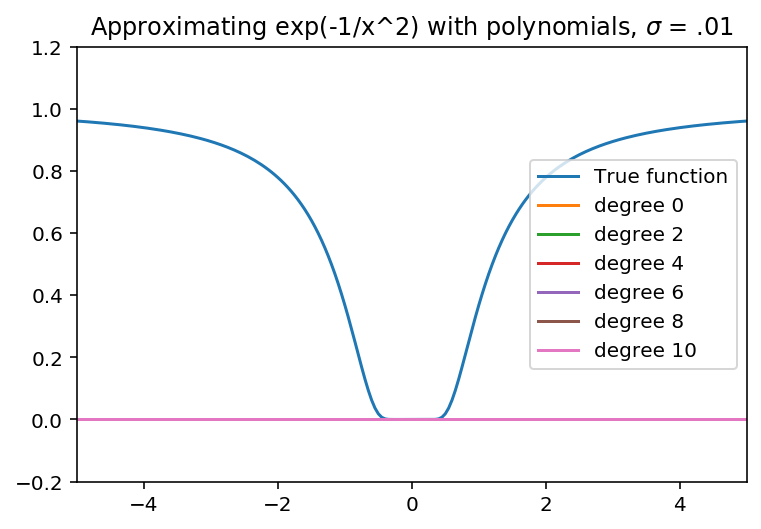

In [198]:
w_hat, R = get_expansion(0.01)

leg = ["True function"]
plt.plot(rg, f(rg))
for i in range(1, nexpansion+1):
    plt.plot(rg, R[:, :i].dot(w_hat[:i]))
    leg.append("degree %d" % ((i - 1) * 2))
plt.legend(leg)
plt.ylim((-.2, 1.2))
plt.xlim((-5, 5))
plt.title('Approximating exp(-1/x^2) with polynomials, $\sigma$ = .01')

Flatter than the great salt flats! We get back to our original conclusion: the Taylor expansion of this function at 0 is exactly 0! The Taylor expansion can be viewed as the limit of a polynomial regression in the limit of an infinitely small range of weighted values.